# Facebook Prophet Colab

In [1]:
# Basic imports for loading data and plotting
import pandas as pd
import matplotlib.pyplot as plt

# For saving and importing serialized model
import json
import urllib.request

# Prophet imports
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_forecast_component
from prophet.plot import plot_seasonality
from prophet.serialize import model_to_json, model_from_json

## Air Passengers example

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/raffg/prophet_presentation/main/data/AirPassengers.csv',
                 names=['ds', 'y'], header=1)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


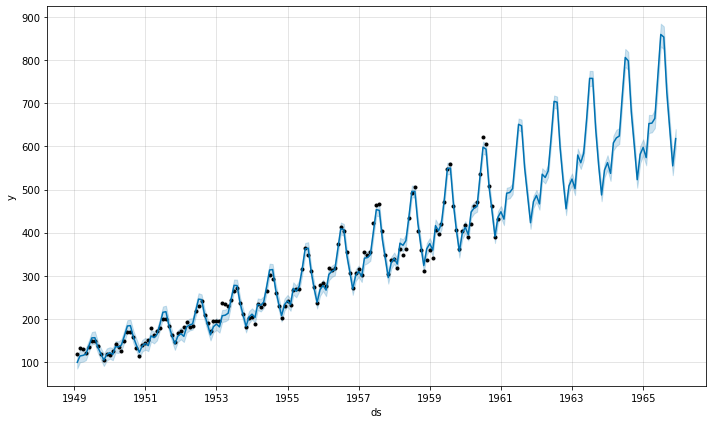

In [3]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=60, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

## Divvy daily example

### Prepare and inspect the data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/raffg/prophet_presentation/main/data/divvy_daily.csv')
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y', 'temperature', 'weather']

In [5]:
df.head()

,ds,y,temperature,weather
0,2014-01-01,95,19.483158,rain or snow
1,2014-01-02,111,16.833333,rain or snow
2,2014-01-03,6,-5.633333,clear
3,2014-01-04,181,30.007735,rain or snow
4,2014-01-05,32,16.756250,rain or snow


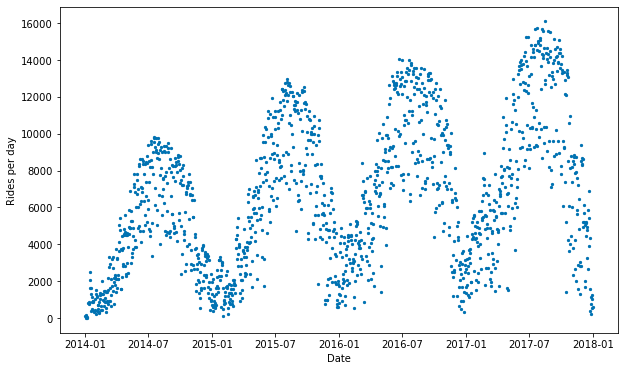

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], s=5, c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Rides per day')
plt.show()

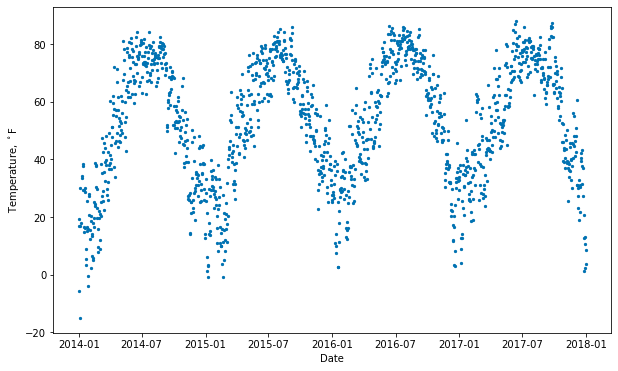

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['temperature'], s=5, c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Temperature, $^\circ$F')
plt.show()

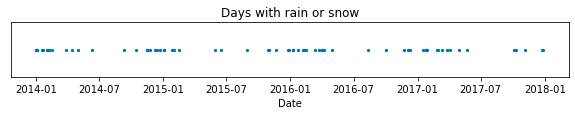

In [8]:
plt.figure(figsize=(10, 1))
plt.scatter(x=df[df['weather'] == 'rain or snow']['ds'], y=df[df['weather'] == 'rain or snow']['weather'], s=5, c='#0072B2')
plt.xlabel('Date')
plt.title('Days with rain or snow')
plt.yticks([])
plt.show()

In [9]:
# Remove final 2 weeks of training data
train = df[df['ds'] <= pd.to_datetime('2017-12-18 00:00:00')].copy()

### Train a basic model

In [10]:
model0 = Prophet()
model0.fit(train)
future = model0.make_future_dataframe(periods=14 * 24, freq='h')
forecast = model0.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


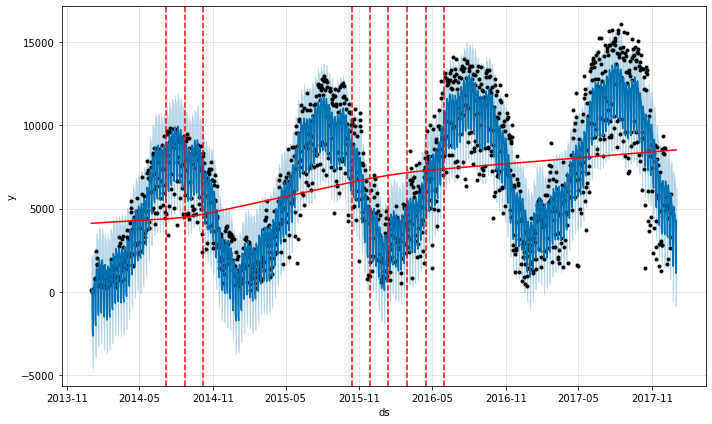

In [11]:
fig = model0.plot(forecast)
add_changepoints_to_plot(fig.gca(), model0, forecast)
plt.show()

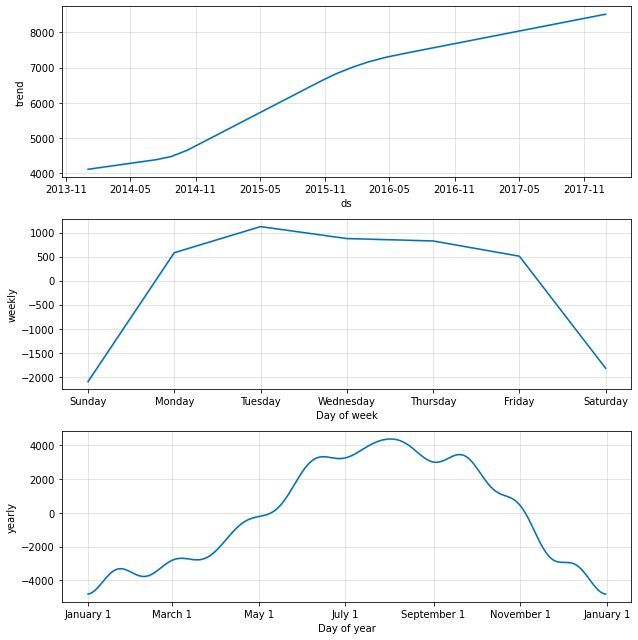

In [12]:
fig2 = model0.plot_components(forecast)
plt.show()

In [13]:
df_cv0 = cross_validation(model0,
                         horizon='14 days',
                         period='7 days',
                         initial='1095 days',
                         parallel='processes')

INFO:prophet:Making 49 forecasts with cutoffs between 2017-01-02 00:00:00 and 2017-12-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D59FE83908>


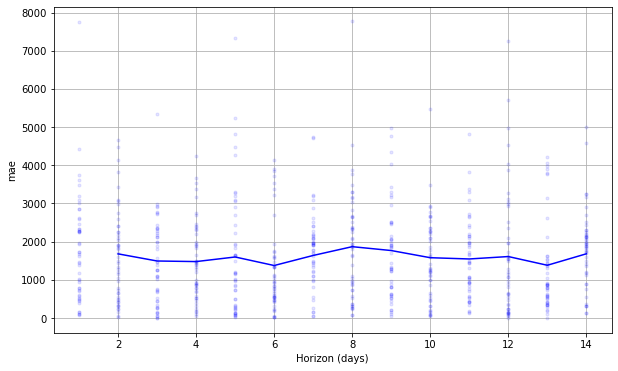

In [14]:
fig = plot_cross_validation_metric(df_cv0, metric='mae')
plt.show()

### Train an advanced model

In [15]:
df['rain_or_snow'] = df['weather'] == 'rain or snow'
train['rain_or_snow'] = train['weather'] == 'rain or snow'

In [16]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4)

#### Add holidays

In [17]:
model.add_country_holidays(country_name='US')

#### Add temperature and precipitation regressors

In [18]:
model.add_regressor('temperature')
model.add_regressor('rain_or_snow')

#### Train, predict, and inspect the model

In [19]:
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
print(model.train_holiday_names)

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object


In [21]:
future = model.make_future_dataframe(periods=14 * 24, freq='h')

future = future.merge(df[['ds', 'temperature', 'rain_or_snow']], on='ds')
future = future.fillna(method='pad')

In [22]:
forecast = model.predict(future)

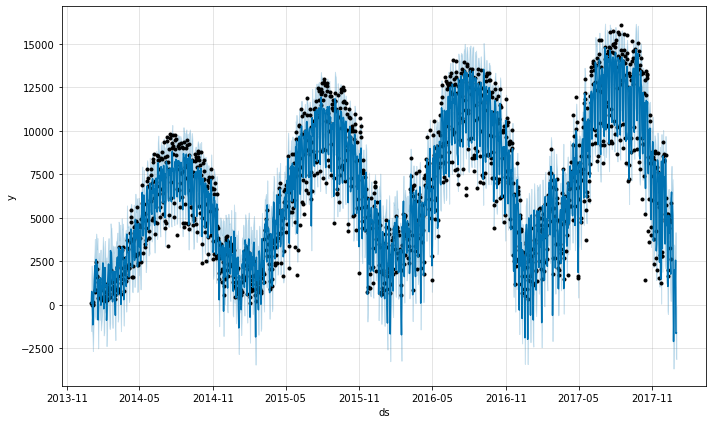

In [23]:
fig = model.plot(forecast)
plt.show()

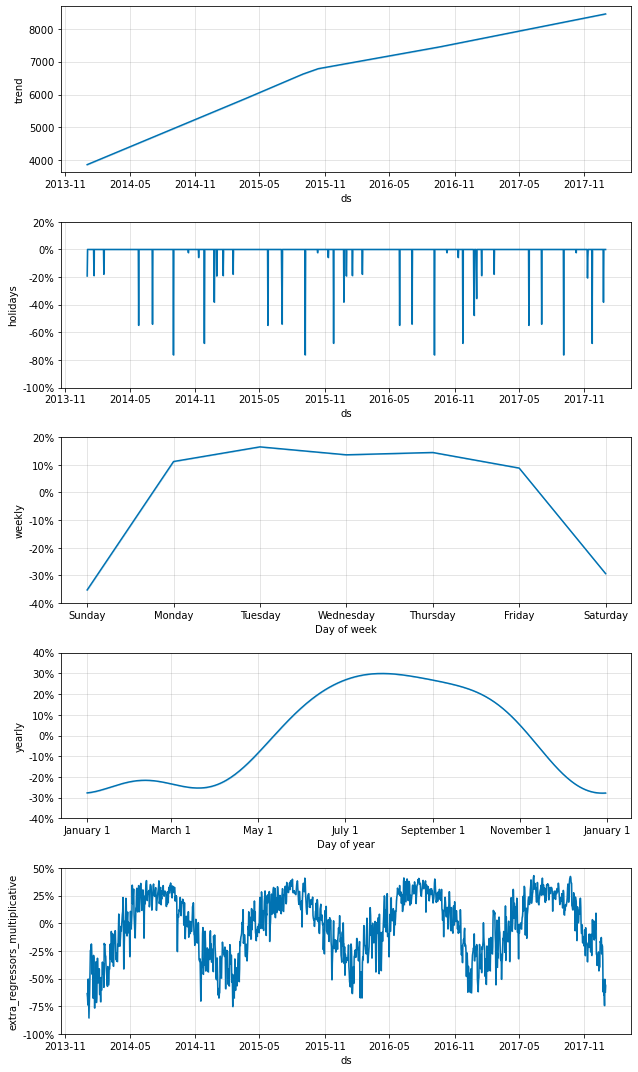

In [24]:
fig2 = model.plot_components(forecast)
plt.show()

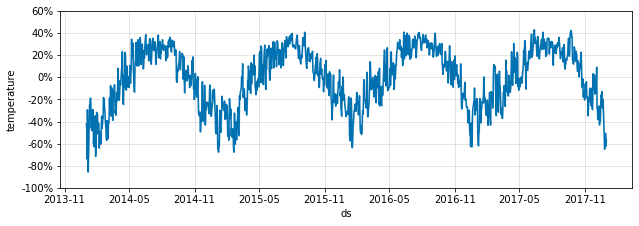

In [25]:
fig3 = plot_forecast_component(model, forecast, 'temperature', figsize=(10.25, 3.25))

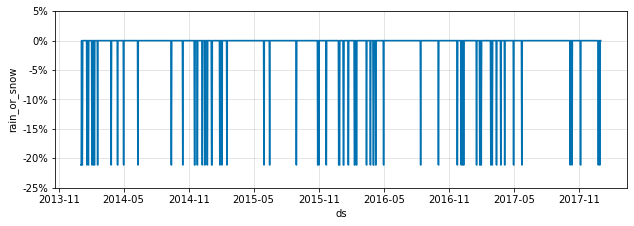

In [26]:
fig4 = plot_forecast_component(model, forecast, 'rain_or_snow', figsize=(10.25, 3.25))

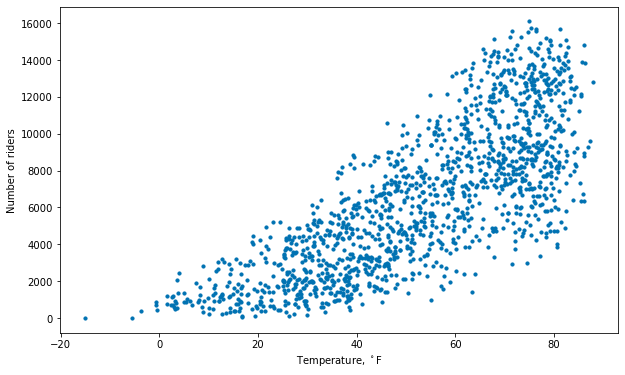

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(df['temperature'], df['y'], s=10, c='#0072B2')
plt.xlabel('Temperature, $^\circ$F')
plt.ylabel('Number of riders')
plt.show()

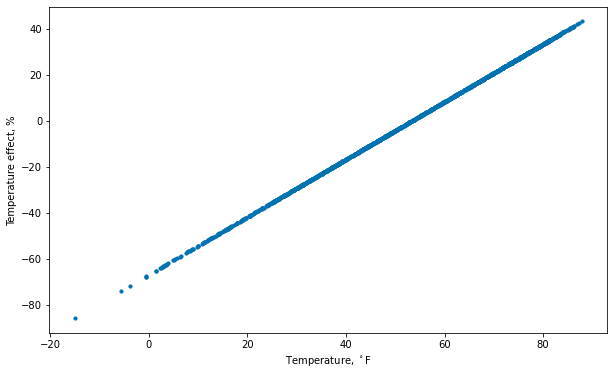

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(df['temperature'], forecast['temperature'] * 100, s=10, c='#0072B2')
plt.xlabel('Temperature, $^\circ$F')
plt.ylabel('Temperature effect, %')
plt.show()

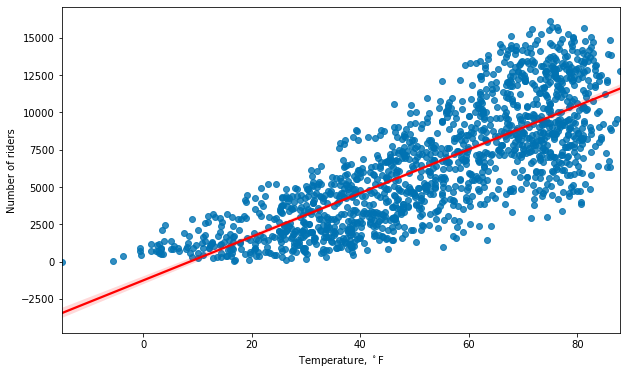

In [29]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.regplot(x=df['temperature'], y=df['y'], scatter_kws={"color": "#0072B2"}, line_kws={"color": "red"})
plt.xlabel('Temperature, $^\circ$F')
plt.ylabel('Number of riders')
plt.show()

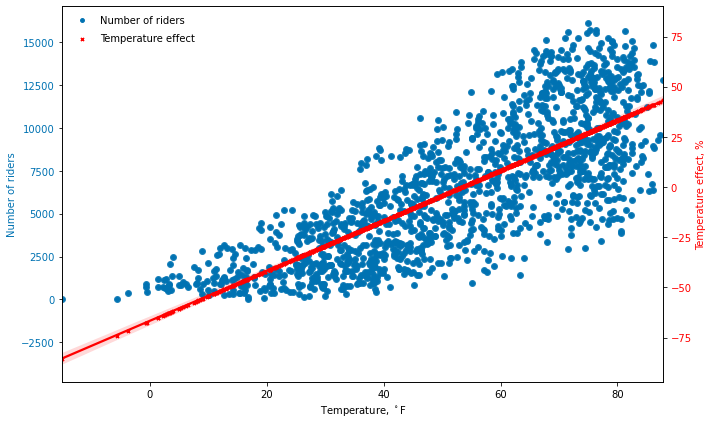

In [30]:
fig, ax1 = plt.subplots(figsize=(10, 6))
color = '#0072B2'
sns.regplot(x=df['temperature'], y=df['y'], scatter_kws={"color": color}, line_kws={"color": "red"})
ax1.set_xlabel('Temperature, $^\circ$F')
ax1.set_ylabel('Number of riders', color=color)
ax1.scatter(df['temperature'], df['y'], s=15, color=color, marker='o', label='Number of riders')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc=(0.01, .94), frameon=False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('Temperature effect, %', color=color)  # we already handled the x-label with ax1
ax2.scatter(df['temperature'], forecast['temperature'] * 100, s=10, color=color, marker='x', label='Temperature effect')
ax2.set_ylim(bottom=-97, top=90)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc=(0.01, .89), frameon=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Evaluate model performance

In [31]:
df_cv = cross_validation(model,
                         horizon='14 days',
                         period='7 days',
                         initial='1095 days',
                         parallel='processes')

INFO:prophet:Making 49 forecasts with cutoffs between 2017-01-02 00:00:00 and 2017-12-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D59FC2FD48>


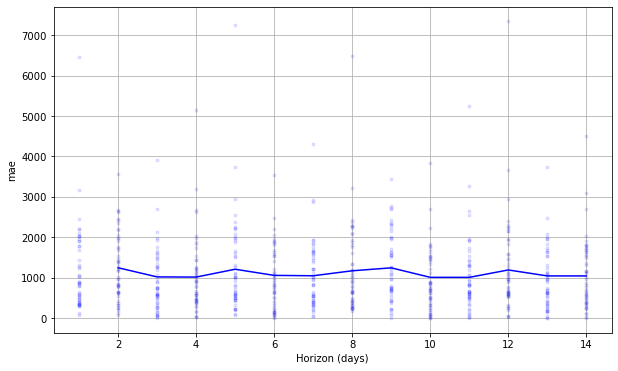

In [32]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.show()

In [33]:
# A yet-to-be-released update to the plot_cross_validation_metric

from prophet.diagnostics import performance_metrics
import numpy as np

def plot_cross_validation_metric_beta(
    df_cv, metric, rolling_window=0.1, ax=None, figsize=(10, 6), color='b',
    point_color='gray'):
    """Plot a performance metric vs. forecast horizon from cross validation.

    Cross validation produces a collection of out-of-sample model predictions
    that can be compared to actual values, at a range of different horizons
    (distance from the cutoff). This computes a specified performance metric
    for each prediction, and aggregated over a rolling window with horizon.

    This uses prophet.diagnostics.performance_metrics to compute the metrics.
    Valid values of metric are 'mse', 'rmse', 'mae', 'mape', and 'coverage'.

    rolling_window is the proportion of data included in the rolling window of
    aggregation. The default value of 0.1 means 10% of data are included in the
    aggregation for computing the metric.

    As a concrete example, if metric='mse', then this plot will show the
    squared error for each cross validation prediction, along with the MSE
    averaged over rolling windows of 10% of the data.

    Parameters
    ----------
    df_cv: The output from prophet.diagnostics.cross_validation.
    metric: Metric name, one of ['mse', 'rmse', 'mae', 'mape', 'coverage'].
    rolling_window: Proportion of data to use for rolling average of metric.
        In [0, 1]. Defaults to 0.1.
    ax: Optional matplotlib axis on which to plot. If not given, a new figure
        will be created.
    figsize: Optional tuple width, height in inches.
    color: Optional color for plot and error points, useful when plotting
        multiple model performances on one axis for comparison.

    Returns
    -------
    a matplotlib figure.
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    # Get the metric at the level of individual predictions, and with the rolling window.
    df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=-1)
    df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)

    # Some work because matplotlib does not handle timedelta
    # Target ~10 ticks.
    tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.
    # Find the largest time resolution that has <1 unit per bin.
    dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
    dt_names = [
        'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
        'nanoseconds'
    ]
    dt_conversions = [
        24 * 60 * 60 * 10 ** 9,
        60 * 60 * 10 ** 9,
        60 * 10 ** 9,
        10 ** 9,
        10 ** 6,
        10 ** 3,
        1.,
    ]
    for i, dt in enumerate(dts):
        if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
            break

    x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
    x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])

    ax.plot(x_plt, df_none[metric], '.', alpha=0.1, c=point_color)
    ax.plot(x_plt_h, df_h[metric], '-', c=color)
    ax.grid(True)

    ax.set_xlabel('Horizon ({})'.format(dt_names[i]))
    ax.set_ylabel(metric)
    return fig

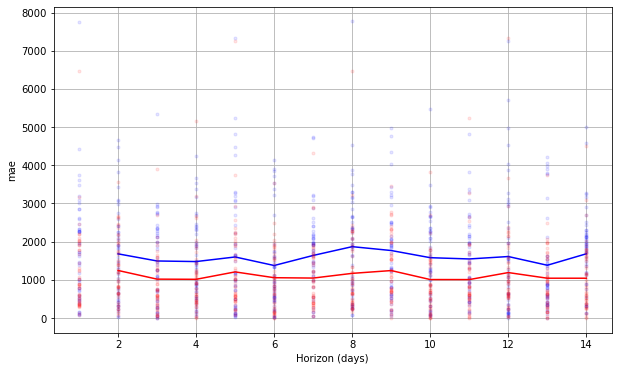

In [34]:
fig = plot_cross_validation_metric_beta(df_cv0, metric='mae', color='b', point_color='b')
plot_cross_validation_metric_beta(df_cv, metric='mae', ax=fig.gca(), color='r', point_color='r')
plt.show()

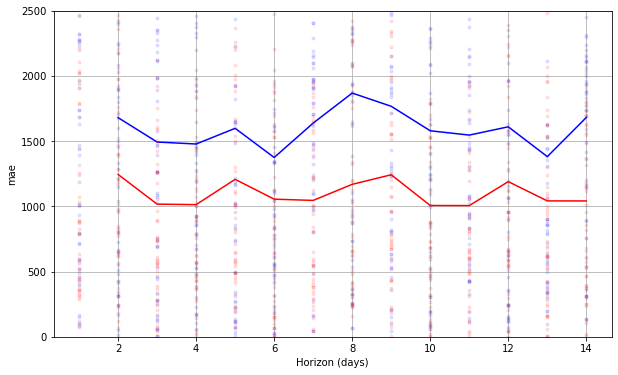

In [35]:
fig = plot_cross_validation_metric_beta(df_cv0, metric='mae', color='b', point_color='b')
plot_cross_validation_metric_beta(df_cv, metric='mae', ax=fig.gca(), color='r', point_color='r')
plt.ylim(0, 2500)
plt.show()

## Divvy hourly example

### Prepare and inspect the data

In [36]:
df = pd.read_csv('https://raw.githubusercontent.com/raffg/prophet_presentation/main/data/divvy_hourly_with_temperature.csv')
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y', 'temperature', 'weather']

In [37]:
df.head()

,ds,y,temperature,weather
0,2014-01-01 01:00:00,1,10.9,not clear
1,2014-01-01 02:00:00,9,10.9,not clear
2,2014-01-01 03:00:00,4,13.0,not clear
3,2014-01-01 04:00:00,1,14.0,not clear
4,2014-01-01 07:00:00,2,16.1,rain or snow


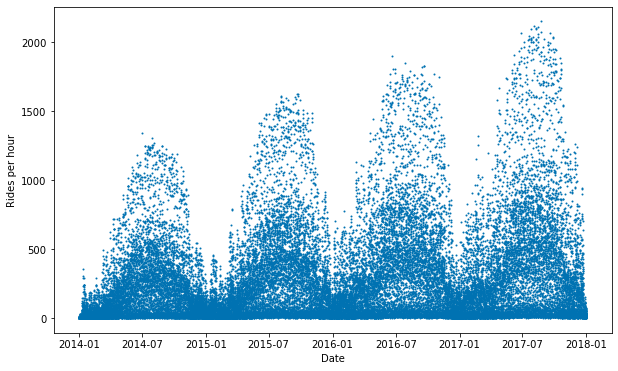

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], s=1, c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Rides per hour')
plt.show()

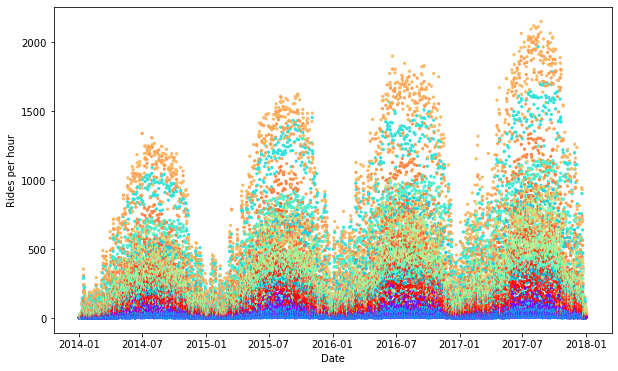

In [39]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
from collections import OrderedDict
import matplotlib.cm as cm

df['hour'] = df['ds'].dt.hour

plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], s=5, c=df['hour'], cmap=cm.rainbow)
plt.xlabel('Date')
plt.ylabel('Rides per hour')
plt.show()

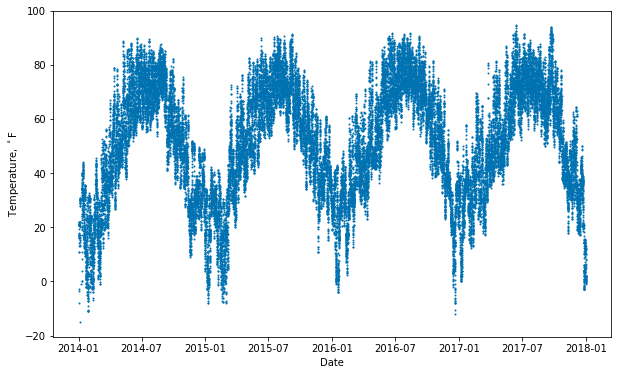

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['temperature'], s=1, c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Temperature, $^\circ$F')
plt.show()

In [41]:
# Remove final 2 weeks of training data
train = df[df['ds'] <= pd.to_datetime('2017-12-18 00:00:00')].copy()

### Train a basic model

In [42]:
model = Prophet()
model.fit(train)
future = model.make_future_dataframe(periods=14 * 24, freq='h')
forecast = model.predict(future)

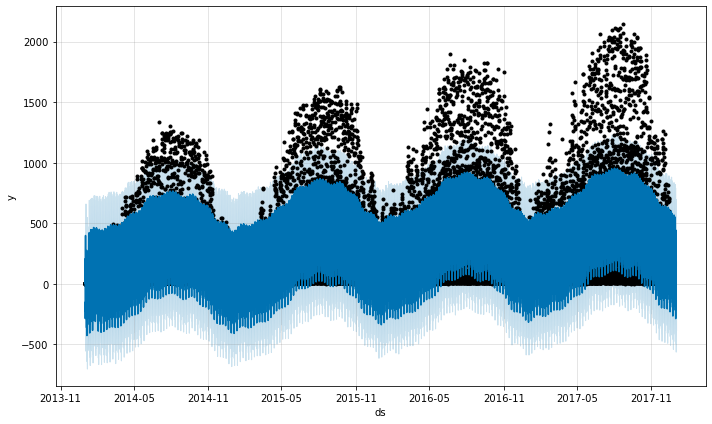

In [43]:
fig = model.plot(forecast)
plt.show()

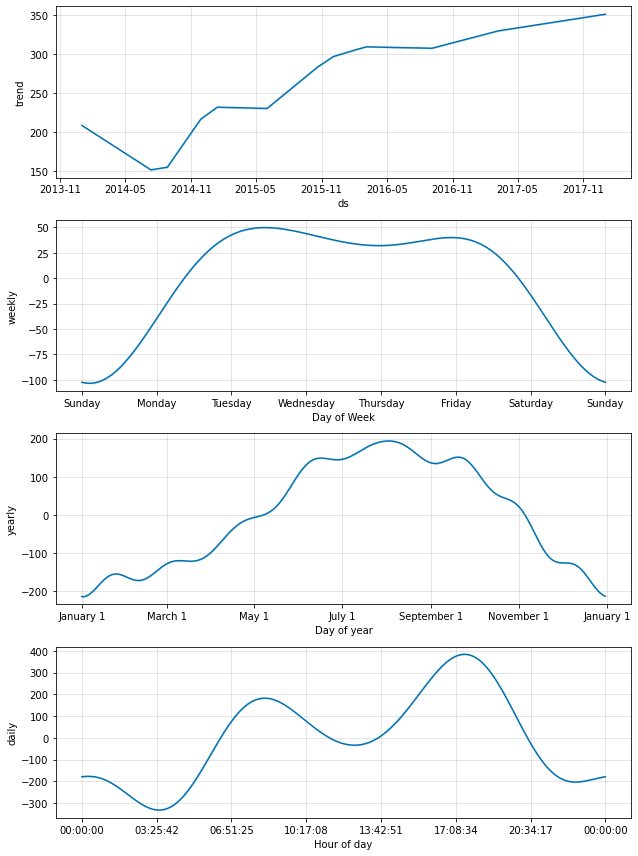

In [44]:
fig2 = model.plot_components(forecast)
plt.show()

### Train an advanced model

In [45]:
df['rain_or_snow'] = df['weather'] == 'rain or snow'
train['rain_or_snow'] = train['weather'] == 'rain or snow'

In [46]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                weekly_seasonality=6,
                daily_seasonality=False,
                changepoint_prior_scale=.001)

#### Add holidays

In [47]:
model.add_country_holidays(country_name='US')

#### Add temperature and precipitation regressors

In [48]:
model.add_regressor('temperature')
model.add_regressor('rain_or_snow')

#### Add conditional seasonality

In [49]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return (date.dayofweek == 5 or date.dayofweek == 6)

In [50]:
df['weekend'] = df['ds'].apply(is_weekend)
df['weekday'] = ~df['ds'].apply(is_weekend)

train['weekend'] = train['ds'].apply(is_weekend)
train['weekday'] = ~train['ds'].apply(is_weekend)

In [51]:
model.add_seasonality(name='daily_weekend',
                      period=1,
                      fourier_order=3,
                      condition_name='weekend')
model.add_seasonality(name='daily_weekday',
                      period=1,
                      fourier_order=3,
                      condition_name='weekday')

#### Train, predict, and inspect the model

In [52]:
model.fit(train)

In [53]:
print(model.train_holiday_names)

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object


In [54]:
future = model.make_future_dataframe(periods=14 * 24, freq='h')

future = future.merge(df[['ds', 'temperature', 'rain_or_snow']], on='ds')
future['weekend'] = future['ds'].apply(is_weekend)
future['weekday'] = ~future['ds'].apply(is_weekend)
future = future.fillna(method='pad')

In [55]:
forecast = model.predict(future)

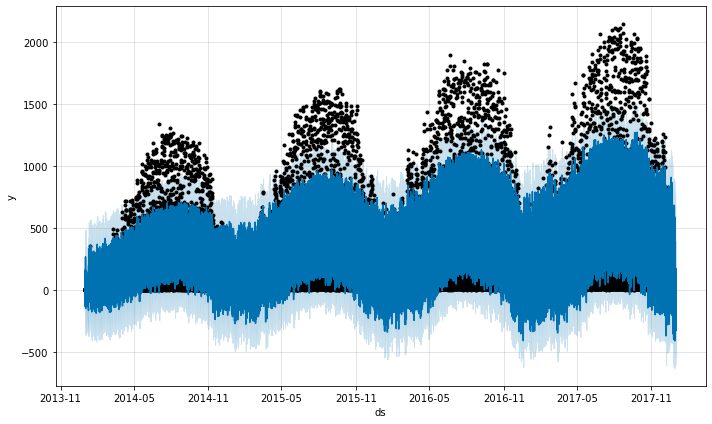

In [56]:
fig = model.plot(forecast)
plt.show()

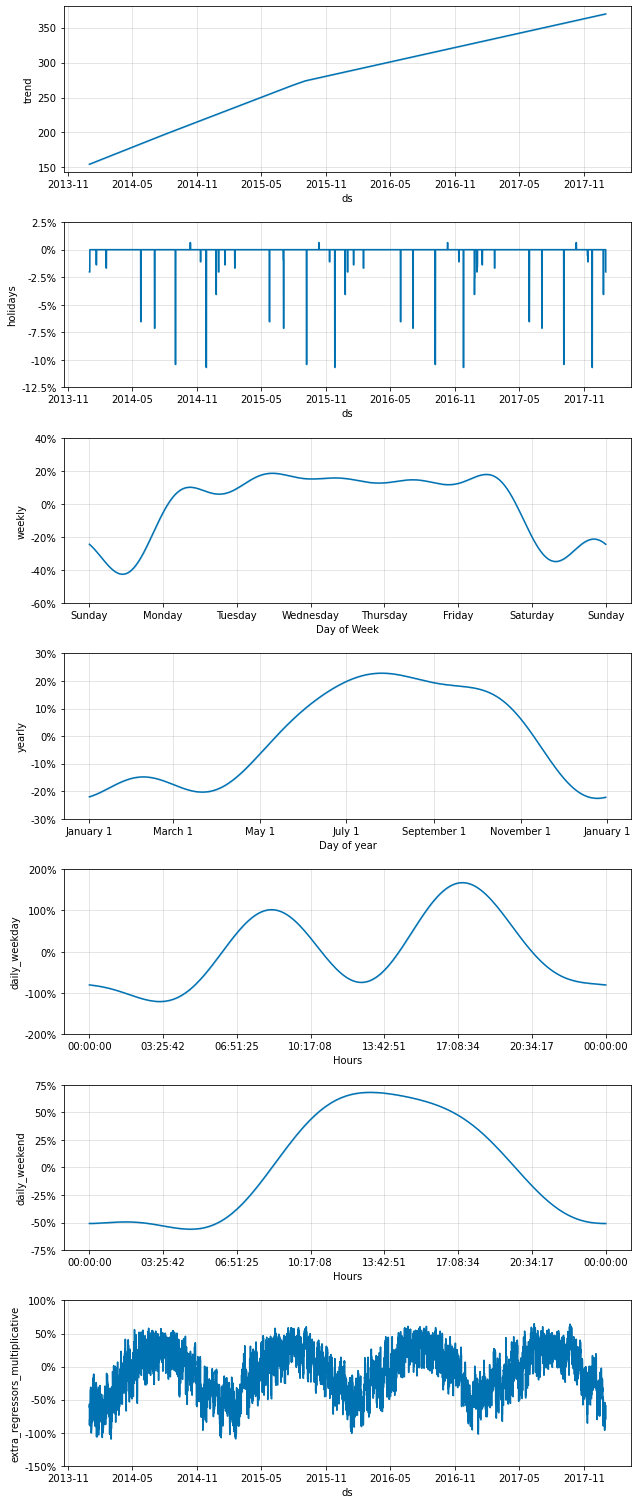

In [57]:
fig2 = model.plot_components(forecast)
plt.show()

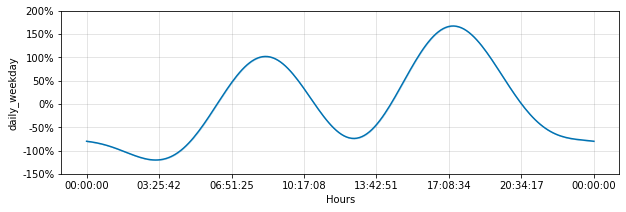

In [58]:
fig3 = plot_seasonality(model, 'daily_weekday', figsize=(10, 3))
plt.show()

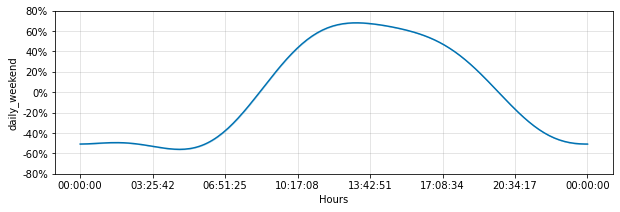

In [59]:
fig4 = plot_seasonality(model, 'daily_weekend', figsize=(10, 3))
plt.show()

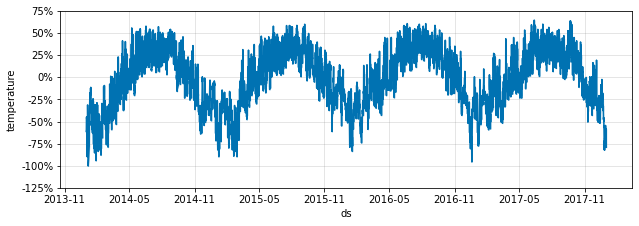

In [60]:
fig5 = plot_forecast_component(model, forecast, 'temperature', figsize=(10.25, 3.25))

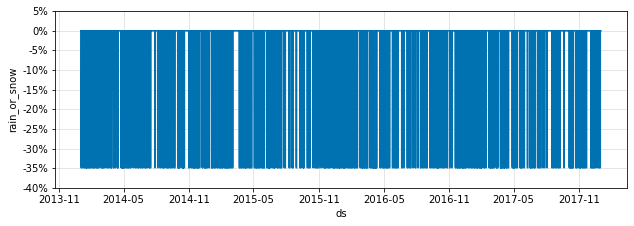

In [61]:
fig6 = plot_forecast_component(model, forecast, 'rain_or_snow', figsize=(10.25, 3.25))

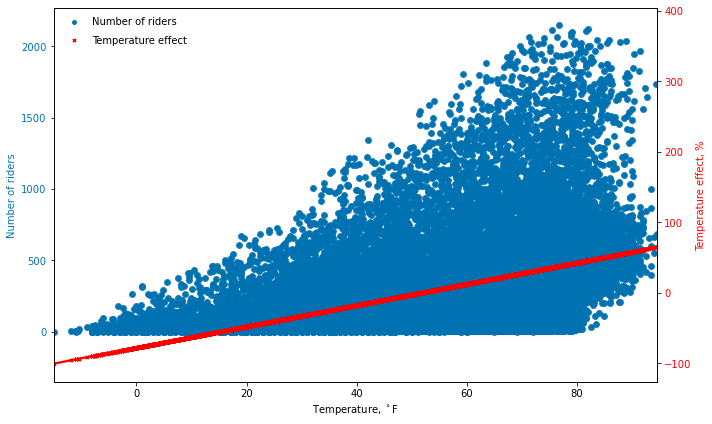

In [62]:
fig7, ax1 = plt.subplots(figsize=(10, 6))
color = '#0072B2'
sns.regplot(x=df['temperature'], y=df['y'], scatter_kws={"color": color}, line_kws={"color": "red"})
ax1.set_xlabel('Temperature, $^\circ$F')
ax1.set_ylabel('Number of riders', color=color)
ax1.scatter(df['temperature'], df['y'], s=15, color=color, marker='o', label='Number of riders')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc=(0.01, .94), frameon=False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('Temperature effect, %', color=color)  # we already handled the x-label with ax1
ax2.scatter(df['temperature'], forecast['temperature'] * 100, s=10, color=color, marker='x', label='Temperature effect')
ax2.set_ylim(bottom=-126, top=404)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc=(0.01, .89), frameon=False)

fig7.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Evaluate model performance

In [63]:
df_cv = cross_validation(model,
                         horizon='14 days',
                         period='7 days',
                         initial='1095 days',
                         parallel='processes')

INFO:prophet:Making 49 forecasts with cutoffs between 2017-01-02 00:00:00 and 2017-12-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D5A9629448>


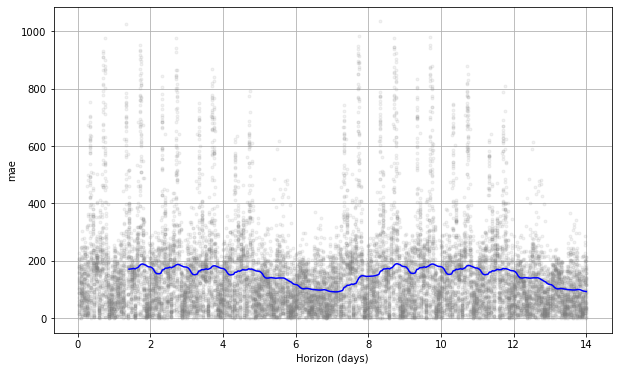

In [64]:
fig = plot_cross_validation_metric_beta(df_cv, metric='mae', point_color='gray')
plt.show()

## Divvy hourly example with MCMC sampling for seasonality uncertainty

### WARNING!!! Will take 8-12 hours! Run the following code if training from scratch.

In [65]:
# model = Prophet(seasonality_mode='multiplicative',
#                 yearly_seasonality=4,
#                 weekly_seasonality=6,
#                 daily_seasonality=False,
#                 changepoint_prior_scale=.001,
#                 mcmc_samples=300)file[-100:]
# # Add holidays and temperature regressor
# model.add_country_holidays(country_name='US')
# model.add_regressor('temperature')
# model.add_regressor('rain_or_snow')
# # Add weekend conditional seasonality
# df['weekend'] = df['ds'].apply(is_weekend)
# df['weekday'] = ~df['ds'].apply(is_weekend)
# train['weekend'] = train['ds'].apply(is_weekend)
# train['weekday'] = ~train['ds'].apply(is_weekend)
# model.add_seasonality(name='daily_weekend',
#                       period=1,
#                       fourier_order=3,
#                       condition_name='weekend')
# model.add_seasonality(name='daily_weekday',
#                       period=1,
#                       fourier_order=3,
#                       condition_name='weekday')
# # Train and predict the model
# model.fit(train)

# # Save fitted model
# with open('divvy_hourly_mcmc.json', 'w') as fout:
#     json.dump(model_to_json(model), fout)
#     files.download('divvy_hourly_mcmc.json')

### Run the following code to load a pre-trained model

In [66]:
file = ''
for i in range(5):
    path = 'https://raw.githubusercontent.com/raffg/prophet_presentation/main/serialized_model/divvy_hourly_mcmc_{}.txt'.format(i)
    file += urllib.request.urlopen(path).read().decode('utf-8')
    
model = model_from_json(json.loads(file))

### Continue with the future predictions

In [67]:
future = model.make_future_dataframe(periods=14 * 24, freq='h')
future = future.merge(df[['ds', 'temperature', 'rain_or_snow']], on='ds')
future['weekend'] = future['ds'].apply(is_weekend)
future['weekday'] = ~future['ds'].apply(is_weekend)
future = future.fillna(method='pad')
forecast = model.predict(future)

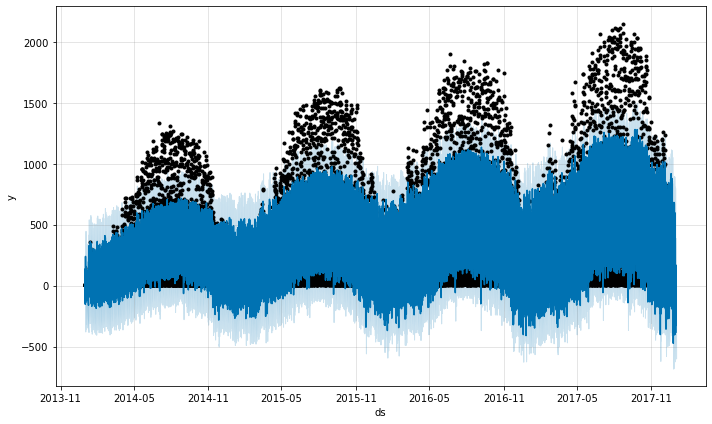

In [68]:
fig = model.plot(forecast)
plt.show()

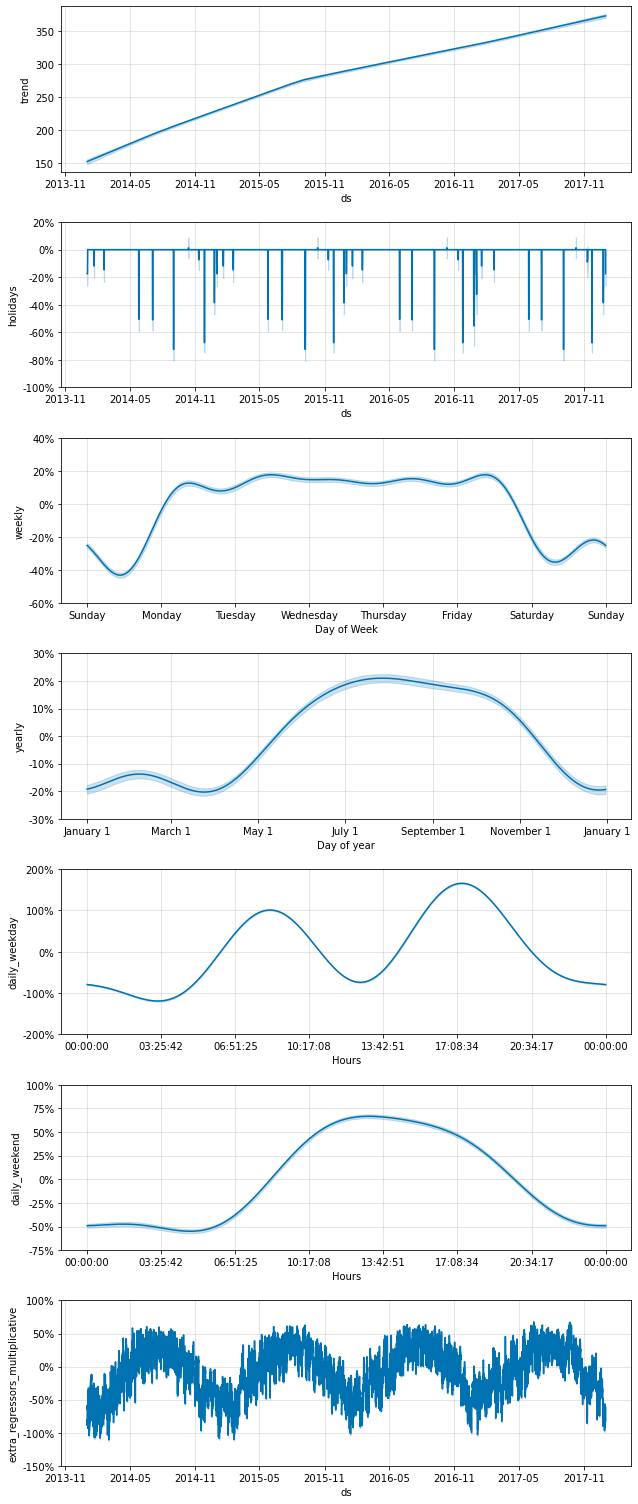

In [69]:
fig2 = model.plot_components(forecast)
plt.show()

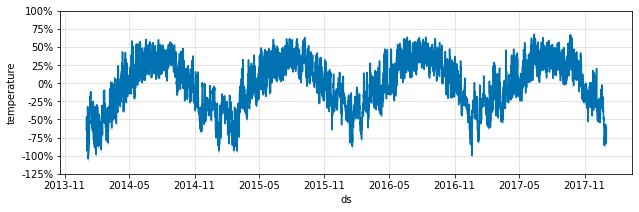

In [70]:
fig3 = plot_forecast_component(model, forecast, 'temperature', figsize=(10.25, 3))

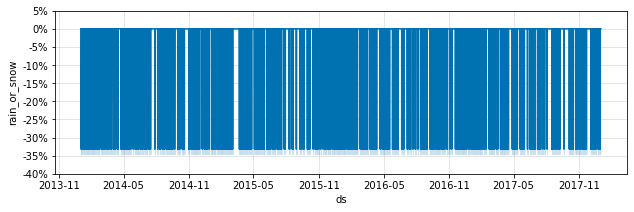

In [71]:
fig4 = plot_forecast_component(model, forecast, 'rain_or_snow', figsize=(10.25, 3))

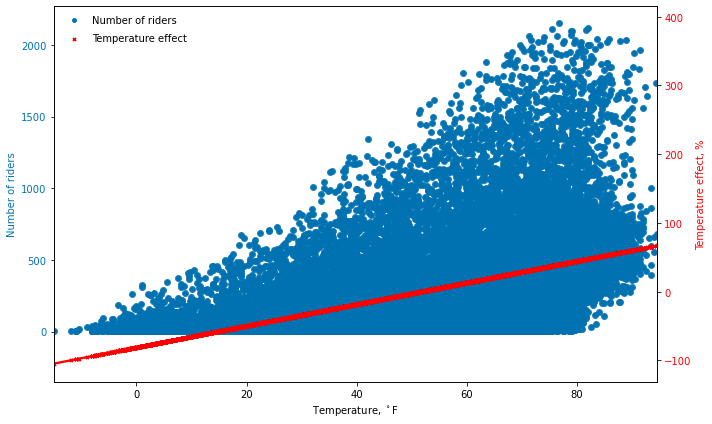

In [72]:
fig5, ax1 = plt.subplots(figsize=(10, 6))
color = '#0072B2'
sns.regplot(x=df['temperature'], y=df['y'], scatter_kws={"color": color}, line_kws={"color": "red"})
ax1.set_xlabel('Temperature, $^\circ$F')
ax1.set_ylabel('Number of riders', color=color)
ax1.scatter(df['temperature'], df['y'], s=15, color=color, marker='o', label='Number of riders')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc=(0.01, .94), frameon=False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('Temperature effect, %', color=color)  # we already handled the x-label with ax1
ax2.scatter(df['temperature'], forecast['temperature'] * 100, s=10, color=color, marker='x', label='Temperature effect')
ax2.set_ylim(bottom=-131, top=415)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc=(0.01, .89), frameon=False)

fig5.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()